In [1]:
# import the necessary packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from keras.layers.merge import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset_url = 'https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database?recency=last7Days'
data_dir = '/content/COVID-19_Radiography_Dataset'


In [6]:
#load training and testing dataset from directory
train_datagen=ImageDataGenerator(rescale = 1./255,
                                   rotation_range=15,
                                   fill_mode="nearest",
                                   horizontal_flip = True)
valid_datagen=ImageDataGenerator(rescale = 1./255)
test_datagen=ImageDataGenerator(rescale = 1./255)

training_set=train_datagen.flow_from_directory('/content/drive/MyDrive/output/train',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical',
                                                 shuffle=True)
valid_set=valid_datagen.flow_from_directory('/content/drive/MyDrive/output/val',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle = False)
test_set=test_datagen.flow_from_directory('/content/drive/MyDrive/output/test',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 14814 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.
Found 2119 images belonging to 4 classes.


In [7]:
print(training_set.class_indices)
print(valid_set.class_indices)
print(test_set.class_indices)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [8]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
#from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, 
                          Dense, Flatten, Dropout)
densenet = DenseNet121(
    weights=None,
    include_top=False,
    input_shape=(224,224,3)
)
model = tf.keras.models.Sequential([densenet,
                                        GlobalAveragePooling2D(),
                                        Dense(512, activation='relu'),
                                        BatchNormalization(),
                                        #Dropout(0.3),
                                        Dense(4, activation='sigmoid')
                                      ])


In [9]:
# compile our model
# initialize the initial learning rate, number of epochs to train for,
INIT_LR = 1e-3
EPOCHS = 5
print(" compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

 compiling model...


In [10]:
#For avoiding overfitting
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [11]:
model.compile(optimizer= Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall'])
history = model.fit_generator(training_set, validation_data = valid_set, epochs=100, verbose=1, callbacks=[early])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/100
232/232 [==============================] - 334s 1s/step - loss: 0.7321 - accuracy: 0.7281 - precision: 0.4778 - recall: 0.8925 - val_loss: 3.8654 - val_accuracy: 0.2873 - val_precision: 0.2462 - val_recall: 0.4168
Epoch 2/100
232/232 [==============================] - 282s 1s/step - loss: 0.5257 - accuracy: 0.8009 - precision: 0.4780 - recall: 0.9602 - val_loss: 3.3993 - val_accuracy: 0.3121 - val_precision: 0.3373 - val_recall: 0.8894
Epoch 3/100
232/232 [==============================] - 283s 1s/step - loss: 0.4706 - accuracy: 0.8245 - precision: 0.4837 - recall: 0.9696 - val_loss: 4.8294 - val_accuracy: 0.4402 - val_precision: 0.3075 - val_recall: 0.9549
Epoch 4/100
232/232 [==============================] - 278s 1s/step - loss: 0.4138 - accuracy: 0.8496 - precision: 0.4908 - recall: 0.9797 - val_loss: 2.9454 - val_accuracy: 0.4846 - val_precision: 0.3613 - val_recall: 0.8913
Epoch 5/100
232/232 [==============================] - 278s 1s/step - loss: 0.3827 - accuracy: 0

In [12]:
model.evaluate(test_set, verbose=1)


34/34 [==============================] - 11s 310ms/step - loss: 1.9114 - accuracy: 0.5908 - precision: 0.3569 - recall: 0.9320


[1.9114457368850708,
 0.5908447504043579,
 0.35694921016693115,
 0.9320434331893921]

In [13]:
#Accuracy, val_acc, loss, val_loss, epoch_range
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

In [14]:
print("accuracy: ",acc)
print("validation accuracy: ",val_acc)
print("loss: ",loss)
print("validation loss: ",val_loss)
print("epochs: ",epochs)

accuracy:  [0.7280950546264648, 0.8009315729141235, 0.8244903683662415, 0.8496017456054688, 0.8600648045539856, 0.8662076592445374, 0.8791683316230774, 0.8883488774299622, 0.8930066227912903, 0.8945592045783997, 0.9063723683357239, 0.9032672047615051]
validation accuracy:  [0.2873345911502838, 0.31214556097984314, 0.44021740555763245, 0.48464083671569824, 0.3329395055770874, 0.5931001901626587, 0.75, 0.5354442596435547, 0.3225425183773041, 0.353497177362442, 0.33010396361351013, 0.610822319984436]
loss:  [0.732117772102356, 0.5257300734519958, 0.4705560803413391, 0.4137621223926544, 0.3826611042022705, 0.3652164041996002, 0.32888203859329224, 0.3081088066101074, 0.29228395223617554, 0.28332066535949707, 0.26572728157043457, 0.25969478487968445]
validation loss:  [3.8653628826141357, 3.3993120193481445, 4.8293867111206055, 2.945358991622925, 3.2482898235321045, 1.8206645250320435, 0.7864187359809875, 1.8307448625564575, 19.830045700073242, 6.55310583114624, 2.3668713569641113, 1.8607772

Text(0.5, 1.0, 'Training and Validation Accuracy')

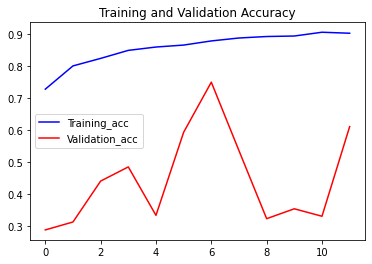

In [15]:
#plot training nad validation accuracy
plt.plot(epochs,acc,label='Training_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

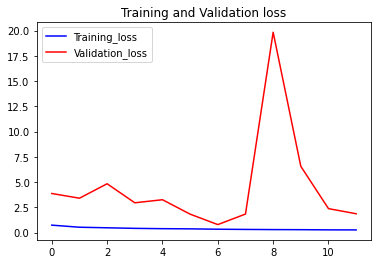

In [16]:
#training and validation loss
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

In [17]:
#model history
import pandas as pd
loss_df = pd.DataFrame(model.history.history)
loss_df

""


In [18]:
#model evaluation on testing

from keras.models import load_model

#model.load_weights("")
model.evaluate(test_set)

34/34 [==============================] - 9s 271ms/step - loss: 1.9114 - accuracy: 0.5908 - precision: 0.3569 - recall: 0.9320


[1.9114457368850708,
 0.5908447504043579,
 0.35694921016693115,
 0.9320434331893921]

In [19]:
#prediction on test data
predictions = np.argmax(model.predict(test_set), axis = -1)

In [20]:
#classification report
print(classification_report(test_set.classes,predictions))

              precision    recall  f1-score   support

           0       0.39      0.81      0.53       362
           1       0.86      0.30      0.44       602
           2       0.67      0.76      0.71      1020
           3       1.00      0.02      0.04       135

    accuracy                           0.59      2119
   macro avg       0.73      0.47      0.43      2119
weighted avg       0.70      0.59      0.56      2119



In [21]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(test_set.classes, predictions)
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

[[295   6  61   0]
 [208 179 215   0]
 [223  22 775   0]
 [ 26   1 105   3]]
sensitivity: 0.9801
specificity: 0.4625


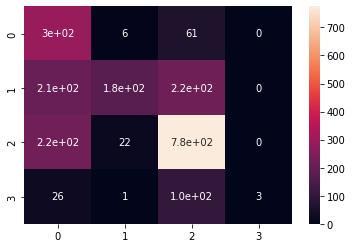

In [22]:
import seaborn as sns
print(confusion_matrix(test_set.classes,predictions))
sns.heatmap(confusion_matrix(test_set.classes,predictions), annot = True)
# show the sensitivity, and specificity
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))